In [1]:
import detector
import scanner
import cv2 as cv
import numpy as np

def imshow(image):
    ww = 1024
    h, w = image.shape[:2]

    if w > ww:
        hh = int(ww / w * h)
        image = cv.resize(image, dsize=[ww, hh])

    _, ret = cv.imencode('.jpg', image) 

    from IPython.display import display, Image
    display(Image(data=ret))
cv.imshow = imshow

/Users/olir/workspace/genshin_artifact_scanner/scanner/artifacts.yaml


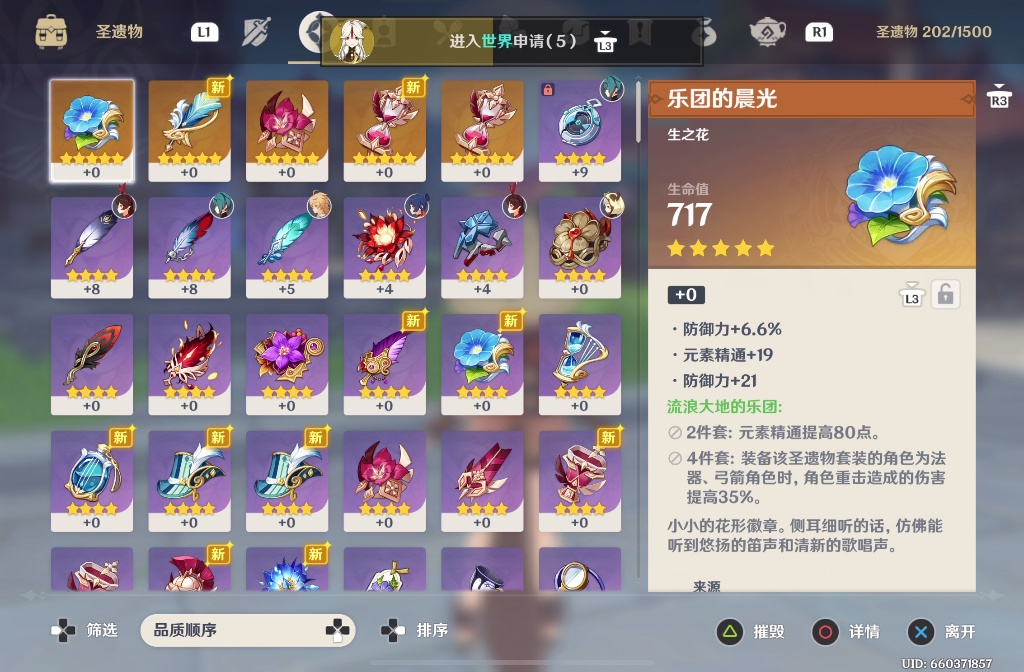

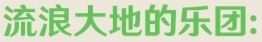

In [2]:
from detector.artifact_set_name import find_artifact_set_name_roi, parse_artifact_set_name
from detector.util import moph
from scanner import ROI







def find_artifact_set_name_roi(screen: np.array, artifact_panel_roi: ROI):
  '''
  screen: colored image
  '''
  panel = artifact_panel_roi.clip_image(screen)
  hsv = cv.cvtColor(panel, cv.COLOR_BGR2HSV)

  h = cv.inRange(hsv[...,0], 50, 58)
  s = cv.inRange(hsv[...,1], 30, 255)
  mask = s & h

  cv.imshow(mask)

  mask = moph(mask, kernel_size=[3, 3], n_iter=5)

  contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  text_contour = min(contours, key=lambda i: cv.boundingRect(i)[1])
  x, y, w, h = cv.boundingRect(text_contour)

  return ROI(x, y, x+w, y+h).translate(*artifact_panel_roi.p1)








filename = '/Users/olir/Desktop/Untitled.mov'
timestamp = 0
reader = scanner.FrameReader(filename, time=timestamp)

video_frame = reader.next()


frame = video_frame.copy()
cv.imwrite("frame.png", frame)
imshow(frame)


gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
lower_panel = ROI(1434, 596, 2159, 1310)


set_name_roi = find_artifact_set_name_roi(frame, lower_panel)

cv.imshow(set_name_roi.clip_image(frame))
# parsed_name = parse_artifact_set_name(gray, set_name_roi)



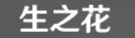

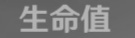

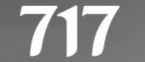

In [3]:
class allroi:
  upper = ROI(1434, 265, 1828, 520)
  lower = ROI(1434, 596, 2159, 1310)
  level = ROI(1476, 632, 1561, 674)
  sub_stats_template = ROI(1500, 700, 2141, 596)

from detector.type_and_main_stat import (
  find_all_text_roi_in_range,
  parse_type,
  parse_main_stat_name, 
  parse_main_stat_value
)

upper_panel_roi = allroi.upper

color_range = dict(lo=150, hi=255)
kernel_size = 10,3
kernel_n_iter = 5
text_rois = find_all_text_roi_in_range(
  gray, upper_panel_roi, color_range, kernel_size, kernel_n_iter)

text_rois.sort(key=lambda r: r.y1)
assert len(text_rois) == 3
artifact_type, main_stat_name, main_stat_value = text_rois

for roi in text_rois:
  cv.imshow(roi.clip_image(gray))

type = parse_type(gray, artifact_type)
main_name = parse_main_stat_name(gray, main_stat_name)
main_value = parse_main_stat_value(gray, main_stat_value)